In [1]:
import argparse
import requests
import random
import pickle
import torch
import json
import glob
import sys
import io

import PIL.Image

import numpy as np

In [2]:
sys.path.append('EDSR-PyTorch/src/')

In [3]:
import utility
import model

In [4]:
%matplotlib inline

The following args datastructure was captured from a run of main.py with the following arguments:  
`$ python main.py --model EDSR --scale 2 --patch_size 96 --save edsr_baseline_x2 --reset`

In [5]:
json_args = '{"debug": false, "template": ".", "n_threads": 6, "cpu": false, "n_GPUs": 1, "seed": 1, "dir_data": "../../../dataset", "dir_demo": "../test", "data_train": ["DIV2K"], "data_test": ["DIV2K"], "data_range": "1-800/801-810", "ext": "sep", "scale": [2], "patch_size": 96, "rgb_range": 255, "n_colors": 3, "chop": false, "no_augment": false, "model": "EDSR", "act": "relu", "pre_train": "download", "extend": ".", "n_resblocks": 16, "n_feats": 64, "res_scale": 1, "shift_mean": true, "dilation": false, "precision": "single", "G0": 64, "RDNkSize": 3, "RDNconfig": "B", "n_resgroups": 10, "reduction": 16, "reset": true, "test_every": 1000, "epochs": 300, "batch_size": 16, "split_batch": 1, "self_ensemble": false, "test_only": false, "gan_k": 1, "lr": 0.0001, "decay": "200", "gamma": 0.5, "optimizer": "ADAM", "momentum": 0.9, "betas": [0.9, 0.999], "epsilon": 1e-08, "weight_decay": 0, "gclip": 0, "loss": "1*L1", "skip_threshold": 100000000.0, "save": "edsr_baseline_x2", "load": "", "resume": 0, "save_models": false, "print_every": 100, "save_results": false, "save_gt": false}'
print(json_args)

{"debug": false, "template": ".", "n_threads": 6, "cpu": false, "n_GPUs": 1, "seed": 1, "dir_data": "../../../dataset", "dir_demo": "../test", "data_train": ["DIV2K"], "data_test": ["DIV2K"], "data_range": "1-800/801-810", "ext": "sep", "scale": [2], "patch_size": 96, "rgb_range": 255, "n_colors": 3, "chop": false, "no_augment": false, "model": "EDSR", "act": "relu", "pre_train": "download", "extend": ".", "n_resblocks": 16, "n_feats": 64, "res_scale": 1, "shift_mean": true, "dilation": false, "precision": "single", "G0": 64, "RDNkSize": 3, "RDNconfig": "B", "n_resgroups": 10, "reduction": 16, "reset": true, "test_every": 1000, "epochs": 300, "batch_size": 16, "split_batch": 1, "self_ensemble": false, "test_only": false, "gan_k": 1, "lr": 0.0001, "decay": "200", "gamma": 0.5, "optimizer": "ADAM", "momentum": 0.9, "betas": [0.9, 0.999], "epsilon": 1e-08, "weight_decay": 0, "gclip": 0, "loss": "1*L1", "skip_threshold": 100000000.0, "save": "edsr_baseline_x2", "load": "", "resume": 0, "sa

In [6]:
args = argparse.Namespace()
args.__dict__ = json.loads(json_args)
args

Namespace(G0=64, RDNconfig='B', RDNkSize=3, act='relu', batch_size=16, betas=[0.9, 0.999], chop=False, cpu=False, data_range='1-800/801-810', data_test=['DIV2K'], data_train=['DIV2K'], debug=False, decay='200', dilation=False, dir_data='../../../dataset', dir_demo='../test', epochs=300, epsilon=1e-08, ext='sep', extend='.', gamma=0.5, gan_k=1, gclip=0, load='', loss='1*L1', lr=0.0001, model='EDSR', momentum=0.9, n_GPUs=1, n_colors=3, n_feats=64, n_resblocks=16, n_resgroups=10, n_threads=6, no_augment=False, optimizer='ADAM', patch_size=96, pre_train='download', precision='single', print_every=100, reduction=16, res_scale=1, reset=True, resume=0, rgb_range=255, save='edsr_baseline_x2', save_gt=False, save_models=False, save_results=False, scale=[2], seed=1, self_ensemble=False, shift_mean=True, skip_threshold=100000000.0, split_batch=1, template='.', test_every=1000, test_only=False, weight_decay=0)

Add the following argument to download pretrained weights:

In [7]:
args.pre_train = 'download'
#args.scale = [4]

In [8]:
checkpoint = utility.checkpoint(args)

In [9]:
net = model.Model(args, checkpoint)

Making model...
Download the model


In [10]:
nemo_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/f6/Clown_fish_in_the_Andaman_Coral_Reef.jpg/320px-Clown_fish_in_the_Andaman_Coral_Reef.jpg'

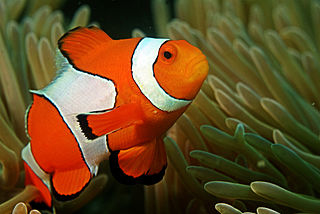

In [11]:
im = PIL.Image.open(io.BytesIO(requests.get(nemo_url).content))
im

In [12]:
a0 = np.array(im, dtype=np.float32)
a0.shape

(214, 320, 3)

In [13]:
a1 = a0.reshape((1,) + a0.shape).transpose(0, 3, 2, 1)
a1.shape

(1, 3, 320, 214)

In [14]:
a1.min(), a1.mean(), a1.max()

(0.0, 70.76729, 255.0)

In [15]:
x = torch.from_numpy(a1).to('cuda')
x.shape

torch.Size([1, 3, 320, 214])

In [16]:
%time y0 = net(x, idx_scale=0).to('cpu').detach().numpy()
y0.shape

CPU times: user 884 ms, sys: 80 ms, total: 964 ms
Wall time: 124 ms


(1, 3, 640, 428)

In [17]:
y1 = y0[0].transpose(2, 1, 0)

In [18]:
y1.min(), y1.mean(), y1.max()

(-81.00081, 70.737625, 328.4439)

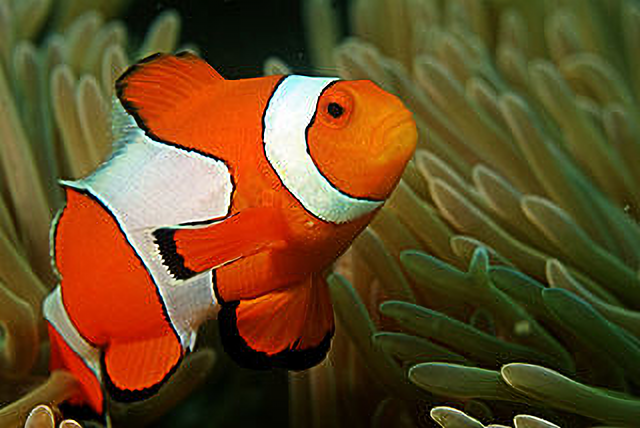

In [19]:
PIL.Image.fromarray(y1.clip(0, 255).astype(np.uint8))

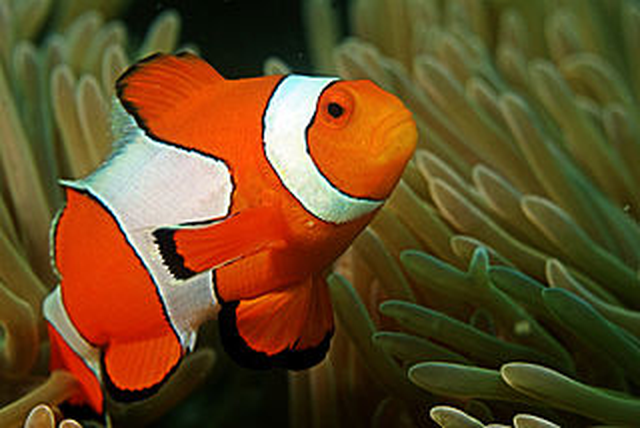

In [21]:
im.resize((2 * im.size[0], 2 * im.size[1]), resample=PIL.Image.LANCZOS)